# **Task 1: Data preparation and customer analytics**

- Creating and interpreting high level summaries of the data
- Finding outliers and removing these (if applicable)
- Checking data formats and correcting (if applicable)
- Derive extra features such as pack size and brand name from the data 

### Import libraries

In [1]:
#import preprocessing libraries
import numpy as np
import pandas as pd

#import visualisation library
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from mlxtend.frequent_patterns import apriori, association_rules

**LIFESTAGE**: Customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school.

**PREMIUM_CUSTOMER**: Customer segmentation used to differentiate shoppers by the price point of products they buy and the types of products they buy. It is used to identify whether customers may spend more for quality or brand or whether they will purchase the cheapest options.



### Read data files

In [2]:
df_purchase = pd.read_csv('QVI_purchase_behaviour.csv')

In [3]:
df_transaction = pd.read_excel('QVI_transaction_data.xlsx')

## Exploratory data analysis

### Examining customer data

In [4]:
#print first few rows of customer dataset
df_purchase.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [5]:
#Customer data summary
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [6]:
df_purchase['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [7]:
df_purchase.groupby('LIFESTAGE').size().sort_values(ascending=False)

LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
dtype: int64

In [8]:
df_purchase['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [9]:
df_purchase.groupby('PREMIUM_CUSTOMER').size().sort_values(ascending=False)

PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
dtype: int64

### Examining transaction data

In [10]:
#print first few rows of transaction dataset
df_transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [11]:
#Transaction data summary
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


The format of 'DATE' column is integer. Change it to 'datetime' 

#### Examine transaction data

In [12]:
#change the format of 'DATE' column
df_transaction['DATE'] = pd.to_datetime(df_transaction['DATE'], unit='D', origin='1899-12-30')
df_transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [13]:
df_transaction['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 264836 entries, 0 to 264835
Series name: DATE
Non-Null Count   Dtype         
--------------   -----         
264836 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.0 MB


#### Examine PROD_NAME

- Examine the words in PROD_NAME to see if there are any incorrect entries such as products that are not chips
- As we are only interested in words that will tell us if the product is chips or not, let's remove all words with digits and special characters such as '&' from our set of product words.
- Then sort the distinct words by frequency of occurrence in order of highest to lowest frequency

In [14]:
import re
from collections import Counter


# Get unique product names
unique_product_names = df_transaction['PROD_NAME'].unique()

# Initialize a Counter to store word frequency
word_frequency = Counter()

# Define a regex pattern to match special characters and digits
pattern = re.compile(r'[^a-zA-Z]')  # This pattern will match anything that is not a letter

# Process each unique product name
for name in unique_product_names:
    words = name.split()
    cleaned_words = [pattern.sub('', word) for word in words if pattern.sub('', word)]  # Remove empty words
    word_frequency.update(cleaned_words)

# Convert the Counter to a DataFrame
word_frequency_df = pd.DataFrame.from_dict(word_frequency, orient='index', columns=['frequency'])
word_frequency_df.index.name = 'word'

# Sort the DataFrame by frequency in descending order
word_frequency_df = word_frequency_df.sort_values(by='frequency', ascending=False)

# Print the resulting DataFrame
word_frequency_df.head(20)

,frequency
word,
g,105
Chips,21
Smiths,16
Cut,14
Crinkle,14
Kettle,13
Salt,12
Cheese,12
Original,10


There are salsa products in the dataset but we are only interested in the chips
category, so let's remove these.

In [15]:
salsa = df_transaction['PROD_NAME'].str.contains('Salsa', case=False)
df_transaction = df_transaction[~salsa]

check summary statistics such as mean, min and max values for each feature to see if there are any obvious outliers in the data and if there are any nulls in any of the columns and possible outliers

In [16]:
#statistical summary
df_transaction.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [17]:
#basic summary
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            246742 non-null  datetime64[ns]
 1   STORE_NBR       246742 non-null  int64         
 2   LYLTY_CARD_NBR  246742 non-null  int64         
 3   TXN_ID          246742 non-null  int64         
 4   PROD_NBR        246742 non-null  int64         
 5   PROD_NAME       246742 non-null  object        
 6   PROD_QTY        246742 non-null  int64         
 7   TOT_SALES       246742 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.9+ MB


There are no nulls in the columns but product quantity appears to have an outlier which we should investigate further. Let's investigate further the case where 200 packets of chips are bought in one transaction.

#### Filter the dataset to find the outlier

In [18]:
df_transaction[df_transaction['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There are two transactions where 200 packets of chips are bought in one transaction and both of these transactions were by the same customer. Let's see if the customer has had other transactions

#### Filter out the customer based on the loyalty card number

In [19]:
df_transaction[df_transaction['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We'll remove this loyalty card number from further analysis.

In [20]:
df_transaction = df_transaction[~(df_transaction['LYLTY_CARD_NBR'] == 226000)]

let's look at the number of transaction lines over time to see if there are any obvious data issues such as missing data.

#### Count the number of transactions by date

In [21]:
transaction_date = df_transaction.groupby('DATE').size().reset_index(name='transaction_count')

There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to find the missing date.

#### Create a sequence of dates and join this the count of transactions by date
create a column of dates that includes every day from 1 Jul 2018 to 30 Jun 2019, and join it onto the data to fill in the missing day.

In [22]:
all_date = pd.DataFrame({'DATE': pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')})

transaction_date = pd.merge(transaction_date, all_date, on='DATE', how='outer')
transaction_date.fillna(0, inplace=True)
transaction_date = transaction_date.sort_values(by='DATE')

#### Plot transactions over time

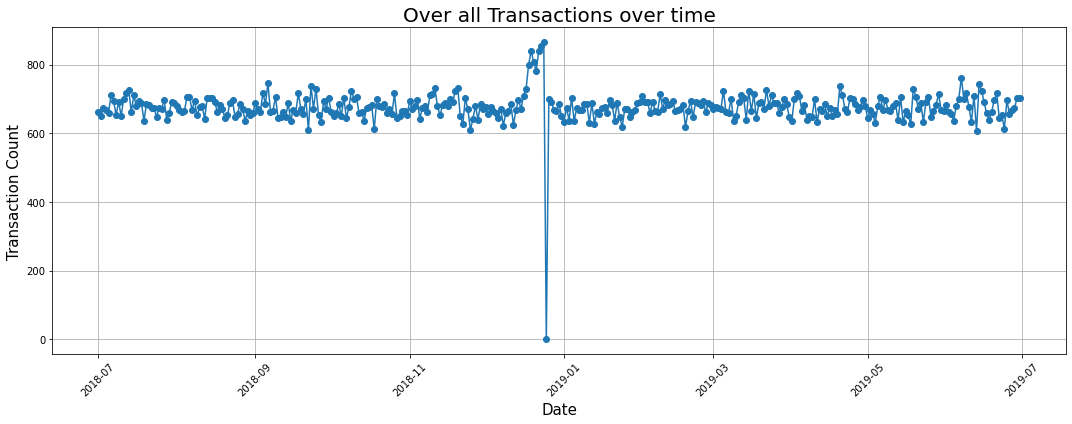

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(transaction_date['DATE'], transaction_date['transaction_count'], marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Transaction Count', fontsize=15)
plt.title('Over all Transactions over time', fontsize=20)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

We can see that there is an increase in purchases in December and a break in late December. Let's zoom in on this.
#### Filter to December and look at individual days

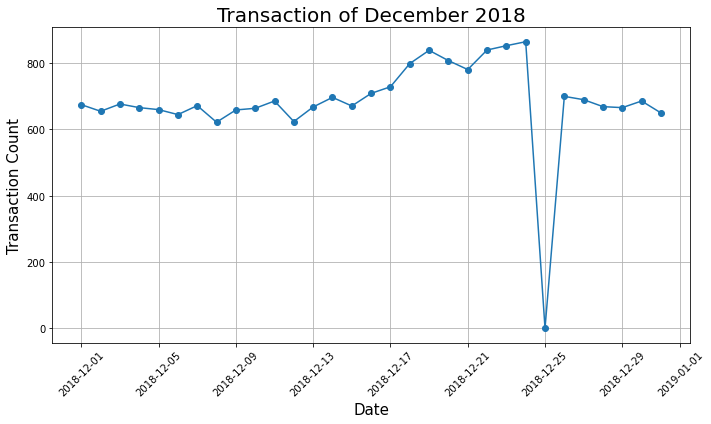

In [26]:
december_data = transaction_date[transaction_date['DATE'].dt.month == 12]

plt.figure(figsize=(10, 6))
plt.plot(december_data['DATE'], december_data['transaction_count'], marker='o')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Transaction Count',fontsize=15)
plt.title('Transaction of December 2018',fontsize=20)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.
Now that we are satisfied that the data no longer has outliers, we can move on tocreating other features such as brand of chips or pack size from PROD_NAME. We will start with pack size.

#### Pack size
The largest size is 380g and the smallest size is 70g - seems sensible!

In [35]:
df_transaction['PACK_SIZE'] = df_transaction['PROD_NAME'].str.extract(r'(\d+)').astype(int)

In [36]:
value_count = df_transaction['PACK_SIZE'].value_counts()
value_count

175    66390
150    40203
134    25102
110    22387
170    19983
165    15297
330    12540
380     6416
270     6285
210     6272
200     4473
135     3257
250     3169
90      3008
190     2995
160     2970
220     1564
70      1507
180     1468
125     1454
Name: PACK_SIZE, dtype: int64

#### Let's plot a histogram of PACK_SIZE 
since we know that it is a categorical variable and not a continuous variable even though it is numeric.

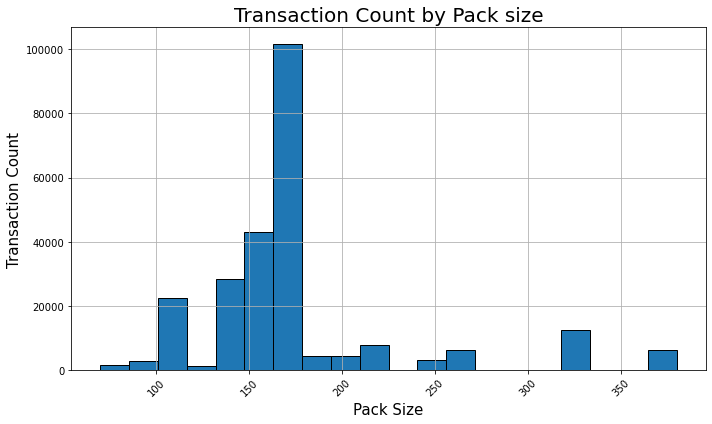

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(value_count.index, bins=20, edgecolor='black', weights=value_count.values)
plt.xlabel('Pack Size', fontsize=15)
plt.ylabel('Transaction Count', fontsize=15)
plt.title('Transaction Count by Pack size', fontsize=20)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

#### Brands
Create a column which contains the brand of the product, by extracting it from the product name.

In [38]:
df_transaction['BRAND'] = df_transaction['PROD_NAME'].str.split().str[0]

In [39]:
df_transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle


In [40]:
df_transaction['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let's combine these together.

In [41]:
replace_dict = {'Natural':'NCC', 'Woolworths':'WW', 'Infzns':'Infuzions', 'Snbts':'Sunbites', 'Red':'RRD', 'Smiths':'Smith', 'Dorito':'Doritos','Grain':'GrnWves'}
df_transaction['BRAND'] = df_transaction['BRAND'].replace(replace_dict)
df_transaction['BRAND'].unique()

array(['NCC', 'CCs', 'Smith', 'Kettle', 'GrnWves', 'Doritos', 'Twisties',
       'WW', 'Thins', 'Burger', 'Cheezels', 'Infuzions', 'RRD',
       'Pringles', 'Tyrrells', 'Cobs', 'French', 'Tostitos', 'Cheetos',
       'Sunbites'], dtype=object)

In [44]:
brand = df_transaction.groupby('BRAND').size().sort_values(ascending=False)

In [54]:
brand.index

Index(['Kettle', 'Smith', 'Doritos', 'Pringles', 'RRD', 'Infuzions', 'Thins',
       'WW', 'Cobs', 'Tostitos', 'Twisties', 'GrnWves', 'NCC', 'Tyrrells',
       'Cheezels', 'CCs', 'Sunbites', 'Cheetos', 'Burger', 'French'],
      dtype='object', name='BRAND')

In [43]:
df_transaction.isnull().sum().sum()

0

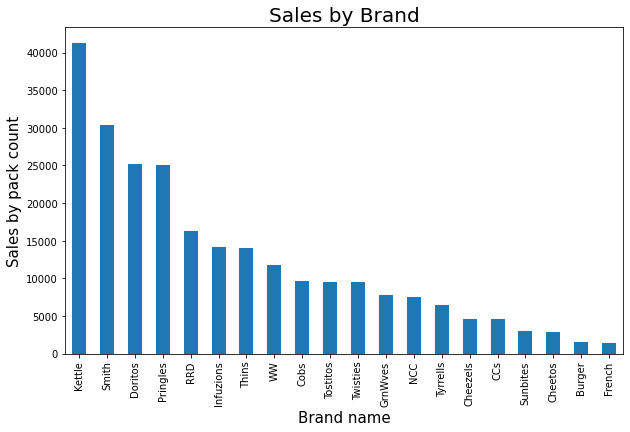

In [67]:
brand.plot(kind='bar', figsize=(10, 6))
plt.title('Sales by Brand', fontsize=20)
plt.xlabel('Brand name', fontsize=15)
plt.ylabel('Sales by pack count', fontsize=15)
plt.show()

#### Merge transaction data to customer data

In [68]:
data = pd.merge(df_transaction, df_purchase, how='left')

As the number of rows in **data** is the same as that of **df_transaction**, we can be sure that no duplicates were created. This is because we created **data** by setting **how='inner'** (in other words, a left join) which means take all the rows in **df_transaction** and find rows with matching values in shared columns and then joining the details in these rows to the **LYLTY_CARD_NBR** or the first mentioned table.

Let's also check if some customers were not matched on by checking for nulls.

In [69]:
data.isnull().sum().sum()

0

Great, there are no nulls! So all our customers in the transaction data has been accounted for in the customer dataset.

In [70]:
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NCC,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smith,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smith,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


#### Save the clean data as 'QVI_data.csv'

In [37]:
data.to_csv('QVI_data.csv', index=False)

Data exploration is now complete!
## Data analysis on customer segments
Now that the data is ready for analysis, we can define some metrics of interest to the client:
- Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment

We could also ask our data team for more information. Examples are:
- The customer's total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips
- Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips
Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and
plotting the split by these segments to describe which customer segment contribute
most to chip sales.

#### Total sales by LIFESTAGE and PREMIUM_CUSTOMER

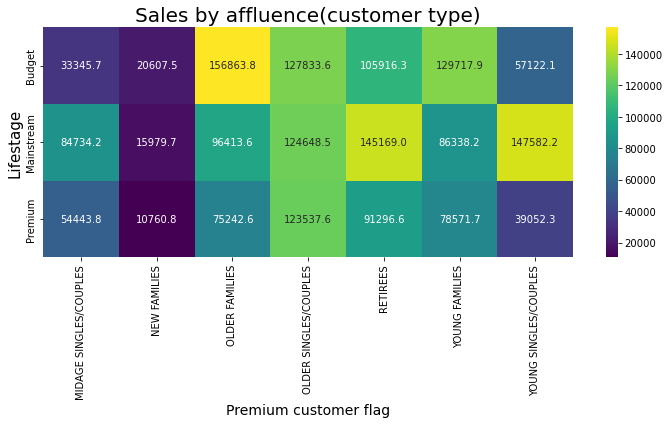

In [72]:
#summaries sale data
sales = data.groupby(by=['LIFESTAGE','PREMIUM_CUSTOMER'])['TOT_SALES'].sum() \
        .reset_index() \
        .rename(columns={'TOT_SALES': 'SALE'}) \
        .sort_values(by='SALE', ascending=False)


# Pivot the data for plotting
pivot_sales = sales.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='SALE')


# Create plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sales.T, annot=True, fmt=".1f", cmap='viridis')

# Set labels and title
plt.xlabel('Premium customer flag', fontsize=14)
plt.ylabel('Lifestage', fontsize=15)
plt.title('Sales by affluence(customer type)', fontsize=20)

# Rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

Sales are coming mainly from **Budget - older families, Mainstream - young singles/couples**, and **Mainstream - retirees**

Let's see if the higher sales are due to there being more customers who buy chips.
#### Number of customers by LIFESTAGE and PREMIUM_CUSTOMER

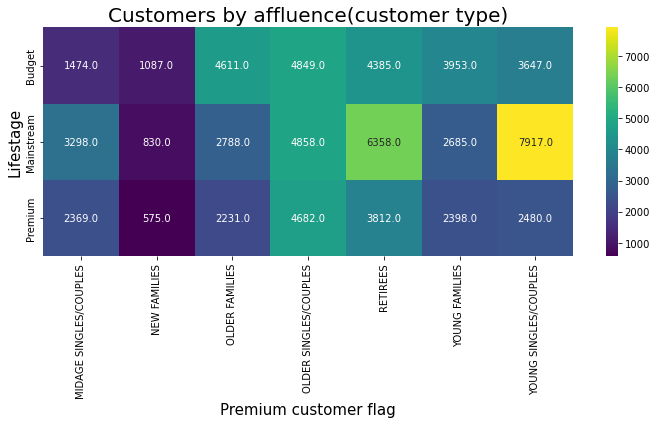

In [80]:
# Grouping and summarizing customer data
customers = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique() \
                .reset_index() \
                .rename(columns={'LYLTY_CARD_NBR': 'CUSTOMERS'}) \
                .sort_values(by='CUSTOMERS', ascending=False)

# Pivot the data for plotting
pivot_customers = customers.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='CUSTOMERS')


# Create the plot using Seaborn's heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_customers.T, annot=True, fmt=".1f", cmap='viridis')

# Set labels and title
plt.xlabel('Premium customer flag', fontsize=15)
plt.ylabel('Lifestage', fontsize=15)
plt.title('Customers by affluence(customer type)', fontsize=20)

# Rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment. Higher sales may also be driven by more units of chips being bought per customer. Let's have a look at this next.

#### Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER

In [74]:
# Grouping and calculating the average units purchased per customer
avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']) \
                .apply(lambda x: (x['PROD_QTY'].sum() / x['LYLTY_CARD_NBR'].nunique())) \
                .reset_index(name='AVG') \
                .sort_values(by='AVG', ascending=False)

print(avg_units)

                 LIFESTAGE PREMIUM_CUSTOMER       AVG
7           OLDER FAMILIES       Mainstream  9.255380
6           OLDER FAMILIES           Budget  9.076773
8           OLDER FAMILIES          Premium  9.071717
15          YOUNG FAMILIES           Budget  8.722995
17          YOUNG FAMILIES          Premium  8.716013
16          YOUNG FAMILIES       Mainstream  8.638361
9    OLDER SINGLES/COUPLES           Budget  6.781398
11   OLDER SINGLES/COUPLES          Premium  6.769543
10   OLDER SINGLES/COUPLES       Mainstream  6.712021
1   MIDAGE SINGLES/COUPLES       Mainstream  6.432080
12                RETIREES           Budget  6.141847
14                RETIREES          Premium  6.103358
2   MIDAGE SINGLES/COUPLES          Premium  6.078514
0   MIDAGE SINGLES/COUPLES           Budget  6.026459
13                RETIREES       Mainstream  5.925920
4             NEW FAMILIES       Mainstream  4.891566
3             NEW FAMILIES           Budget  4.821527
5             NEW FAMILIES  

/Users/hudaquazi/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/hudaquazi/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


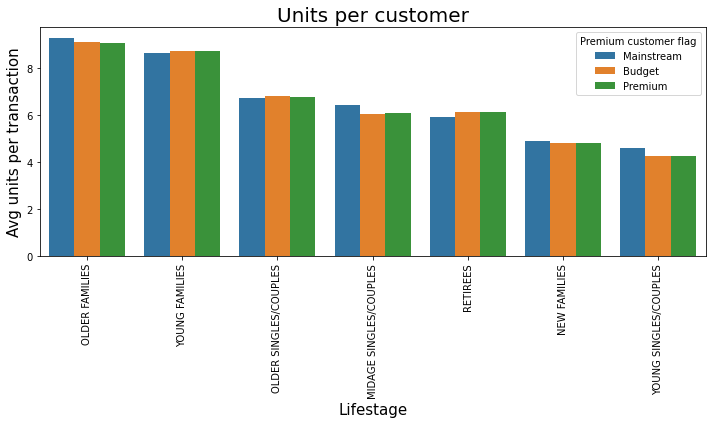

In [75]:
# Create the plot using Seaborn's barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_units, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER', dodge=True)

# Set labels and title
plt.xlabel('Lifestage', fontsize=15)
plt.ylabel('Avg units per transaction', fontsize=15)
plt.title('Units per customer', fontsize=20)

# Rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Display the legend
plt.legend(title='Premium customer flag')

# Display the plot
plt.tight_layout()
plt.show()

Older families and young families in general buy more chips per customer

#### Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER

In [77]:
# Grouping and calculating the average units purchased per customer
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']) \
                .apply(lambda x: (x['TOT_SALES'].sum() / x['PROD_QTY'].sum())) \
                .reset_index(name='AVG') \
                .sort_values(by='AVG', ascending=False)

print(avg_price)

                 LIFESTAGE PREMIUM_CUSTOMER       AVG
19   YOUNG SINGLES/COUPLES       Mainstream  4.074043
1   MIDAGE SINGLES/COUPLES       Mainstream  3.994449
4             NEW FAMILIES       Mainstream  3.935887
12                RETIREES           Budget  3.932731
3             NEW FAMILIES           Budget  3.931969
14                RETIREES          Premium  3.924037
11   OLDER SINGLES/COUPLES          Premium  3.897698
9    OLDER SINGLES/COUPLES           Budget  3.887529
5             NEW FAMILIES          Premium  3.886168
13                RETIREES       Mainstream  3.852986
10   OLDER SINGLES/COUPLES       Mainstream  3.822753
2   MIDAGE SINGLES/COUPLES          Premium  3.780823
15          YOUNG FAMILIES           Budget  3.761903
17          YOUNG FAMILIES          Premium  3.759232
0   MIDAGE SINGLES/COUPLES           Budget  3.753878
6           OLDER FAMILIES           Budget  3.747969
7           OLDER FAMILIES       Mainstream  3.736380
16          YOUNG FAMILIES  

/Users/hudaquazi/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/hudaquazi/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


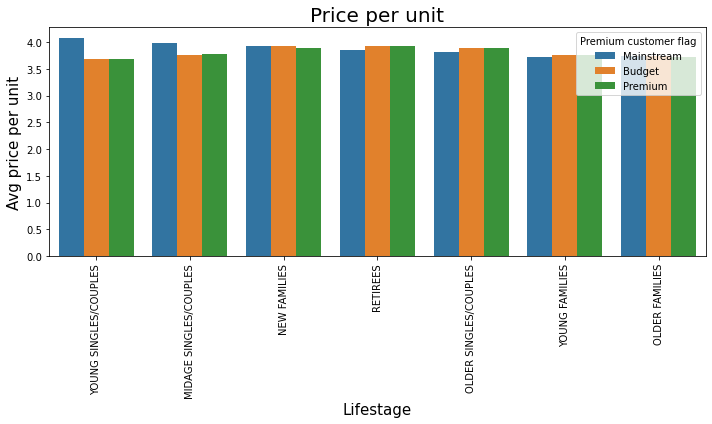

In [78]:
# Create the plot using Seaborn's barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_price, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER', dodge=True)

# Set labels and title
plt.xlabel('Lifestage', fontsize=15)
plt.ylabel('Avg price per unit', fontsize=15)
plt.title('Price per unit', fontsize=20)

# Rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Display the legend
plt.legend(title='Premium customer flag')

# Display the plot
plt.tight_layout()
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.
As the difference in average price per unit isn't large, we can check if this difference is statistically different.

#### Perform an independent t-test between mainstream vs premium and budget midage and young singles and couples

In [44]:
data['PRICE'] = data['TOT_SALES']/data['PROD_QTY']

- **H0** = Mainstream midage and young singles and couples are **NOT** willing to pay more per packet of chips compared to their budget and premium counterparts.
- **HA** = Mainstream midage and young singles and couples are **MORE** willing to pay more per packet of chips compared to their budget and premium counterparts. 

In [45]:
# Subset the data for the two groups
mainstream_group = data[(data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
                        (data['PREMIUM_CUSTOMER'] == "Mainstream")]['PRICE']
premium_budget_group = data[(data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
                            (data['PREMIUM_CUSTOMER'] != "Mainstream")]['PRICE']


In [46]:
# For this analysis, the significance level is 5%

significance_level = 0.05
significance_level

0.05

In [47]:
# Compute your p-value here

# Perform a one-tailed t-test with alternative "greater"
t_statistic, p_value = stats.ttest_ind(mainstream_group, premium_budget_group, alternative='greater')
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 37.83196107667815
P-value: 1.11782280577468e-309


- With a p-value (1.11 e-309) being very very less than 0.05 (as your significance level is 5%) and a t-statistic > 0 (37.83), **reject the null hypothesis.**
- Therefore, you can conclude with 95% confidence interval (i.e. 5% significance level) that **Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts**. 
- The t-test results in a p-value of 1.11 e-309, i.e. the unit price for mainstream, young and mid-age singles and couples **ARE significantly higher** than that of budget or premium, young and midage singles and couples.

#### Deep dive into Mainstream, young singles/couples

We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.

In [48]:
# Create 'segment1' and 'other' DataFrames
segment1 = data[(data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream")]
other = data[~((data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream"))]

# Calculate quantities for segment1 and other
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate proportions for segment1 DataFrame
quantity_segment1_by_brand = segment1.groupby('BRAND').apply(lambda x: x['PROD_QTY'].sum() / quantity_segment1)
quantity_segment1_by_brand = quantity_segment1_by_brand.reset_index(name='targetSegment')

# Calculate proportions for other DataFrame
quantity_other_by_brand = other.groupby('BRAND').apply(lambda x: x['PROD_QTY'].sum() / quantity_other)
quantity_other_by_brand = quantity_other_by_brand.reset_index(name='other')

# Merge the two DataFrames based on BRAND
brand_proportions = pd.merge(quantity_segment1_by_brand, quantity_other_by_brand, on='BRAND')

# Calculate affinityToBrand
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']

# Order by affinityToBrand in descending order
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

brand_proportions


,BRAND,targetSegment,other,affinityToBrand
18,Tyrrells,0.031553,0.025692,1.228095
17,Twisties,0.046184,0.037877,1.219319
5,Doritos,0.122761,0.101075,1.214553
9,Kettle,0.197985,0.165553,1.195897
16,Tostitos,0.045411,0.037978,1.195713
11,Pringles,0.119420,0.100635,1.186670
4,Cobs,0.044638,0.039049,1.143124
8,Infuzions,0.064679,0.057065,1.133435
15,Thins,0.060373,0.056986,1.059423
7,GrnWves,0.032712,0.031188,1.048873


- Mainstream young singles/couples are 22% more likely to purchase Tyrrells chips compared to the rest of the population
- Mainstream youngsingles/couples are 56% less likely to purchase Burger compared to the rest of the population

Let’s also find out if our target segment tends to buy larger packs of chips.

In [49]:

# Create 'segment1' and 'other' DataFrames
segment1 = data[(data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream")]
other = data[~((data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream"))]

# Calculate quantities for segment1 and other
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate proportions for segment1 DataFrame
quantity_segment1_by_pack = segment1.groupby('PACK_SIZE').apply(lambda x: x['PROD_QTY'].sum() / quantity_segment1)
quantity_segment1_by_pack = quantity_segment1_by_pack.reset_index(name='targetSegment')

# Calculate proportions for other DataFrame
quantity_other_by_pack = other.groupby('PACK_SIZE').apply(lambda x: x['PROD_QTY'].sum() / quantity_other)
quantity_other_by_pack = quantity_other_by_pack.reset_index(name='other')

# Merge the two DataFrames based on PACK_SIZE
pack_proportions = pd.merge(quantity_segment1_by_pack, quantity_other_by_pack, on='PACK_SIZE')

# Calculate affinityToPack
pack_proportions['affinityToPack'] = pack_proportions['targetSegment'] / pack_proportions['other']

# Order by affinityToPack in descending order
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)

pack_proportions


,PACK_SIZE,targetSegment,other,affinityToPack
17,270,0.031829,0.025096,1.268287
19,380,0.032160,0.025584,1.257030
18,330,0.061284,0.050162,1.221717
4,134,0.119420,0.100635,1.186670
2,110,0.106280,0.089791,1.183637
14,210,0.029124,0.025121,1.159318
5,135,0.014769,0.013075,1.129511
16,250,0.014355,0.012781,1.123166
9,170,0.080773,0.080986,0.997370
6,150,0.157598,0.163421,0.964372


It looks like Mainstream young singles/couples are 27% more likely to purchase a 270g pack of chips com- pared to the rest of the population but let’s dive into what brands sell this pack size.

In [50]:
data[data['PACK_SIZE'] == 270]['PROD_NAME'].unique()

array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)

Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of purchasing Twisties.

## Conclusion

- Sales have mainly been due to Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees shoppers. 
- We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers. 
- Mainstream, midage and young singles and couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour. 
- We’ve also found that Mainstream young singles and couples are 23% more likely to purchase Tyrrells chips compared to the rest of the population. The Category Manager may want to increase the category’s performance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments where young singles and couples frequent more often to increase visibilty and impulse behaviour.